In [1]:
!python -V

Python 3.11.7


In [2]:
!mkdir data
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet
!mv yellow_tripdata_202* data/

mkdir: cannot create directory ‘data’: File exists
--2024-05-19 19:20:32--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 13.32.23.142, 13.32.23.25, 13.32.23.113, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|13.32.23.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47673370 (45M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2023-01.parquet’

yellow_tripdata_202 100%[===================>]  45.46M  47.9MB/s    in 0.9s    

2024-05-19 19:20:33 (47.9 MB/s) - ‘yellow_tripdata_2023-01.parquet’ saved [47673370/47673370]

--2024-05-19 19:20:33--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 13.32.23.142, 13.32.23.129, 13.32.23.113, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cl

In [2]:
!ls data/

yellow_tripdata_2023-01.parquet  yellow_tripdata_2023-02.parquet


In [3]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [5]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [6]:
df_train = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
df_train.shape

(3066766, 19)

In [7]:
df_train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [8]:
df_train['duration'] = df_train.tpep_dropoff_datetime - df_train.tpep_pickup_datetime
df_train.duration = df_train.duration.apply(lambda td: td.total_seconds() / 60)

In [9]:
df_train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               3066766 non-null  int64         
 1   tpep_pickup_datetime   3066766 non-null  datetime64[us]
 2   tpep_dropoff_datetime  3066766 non-null  datetime64[us]
 3   passenger_count        2995023 non-null  float64       
 4   trip_distance          3066766 non-null  float64       
 5   RatecodeID             2995023 non-null  float64       
 6   store_and_fwd_flag     2995023 non-null  object        
 7   PULocationID           3066766 non-null  int64         
 8   DOLocationID           3066766 non-null  int64         
 9   payment_type           3066766 non-null  int64         
 10  fare_amount            3066766 non-null  float64       
 11  extra                  3066766 non-null  float64       
 12  mta_tax                30667

In [10]:
df_train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


/tmp/ipykernel_6187/632101841.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.duration)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


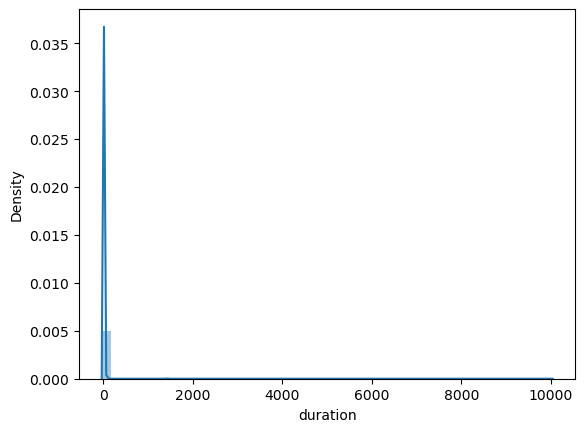

In [11]:
sns.distplot(df_train.duration)
plt.show()

In [12]:
df_train[(df_train.duration >= 1) & (df_train.duration <= 60)].shape[0]/df_train.shape[0]

0.9812202822125979

In [13]:
df_train.duration.describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [14]:
df_train = df_train[(df_train.duration >= 1) & (df_train.duration <= 60)]

/tmp/ipykernel_6187/632101841.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.duration)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


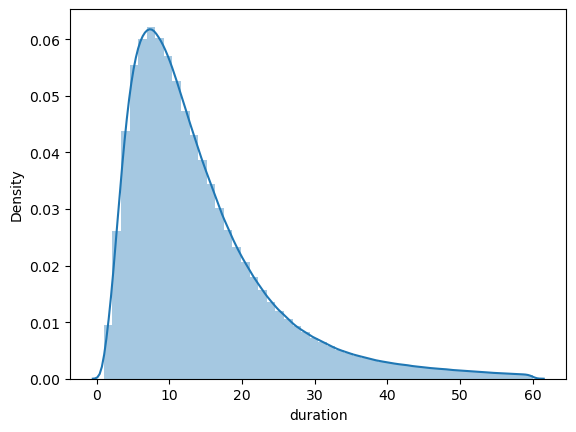

In [15]:
sns.distplot(df_train.duration)
plt.show()

In [16]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df_train[categorical] = df_train[categorical].astype(str)

In [17]:
df_train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [19]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df_train[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)

mean_squared_error(y_train, y_train_pred, squared=False)

7.658406262118744

In [20]:
len(train_dicts), train_dicts[:2]

(3009173,
 [{'PULocationID': '161', 'DOLocationID': '141', 'trip_distance': 0.97},
  {'PULocationID': '43', 'DOLocationID': '237', 'trip_distance': 1.1}])

In [21]:
len(train_dicts), X_train.shape

(3009173, (3009173, 516))

In [22]:
X_train

<3009173x516 sparse matrix of type '<class 'numpy.float64'>'
	with 9027519 stored elements in Compressed Sparse Row format>

/tmp/ipykernel_6187/1890833161.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_pred, label='prediction')
/home/ubuntu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_6187/1890833161.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level 

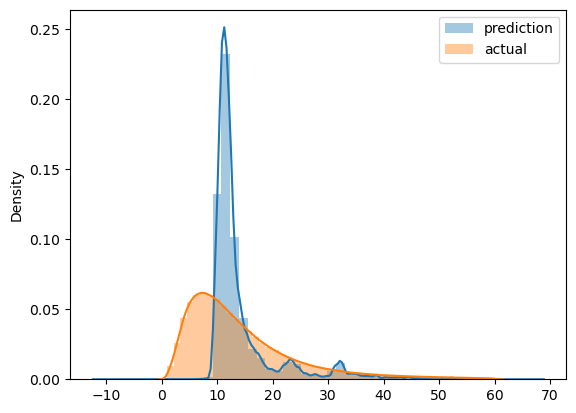

In [23]:
sns.distplot(y_train_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [24]:
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [25]:
len(df_val)

2855951

In [26]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [27]:
target = 'duration'
y_val = df_val[target].values

In [28]:
y_val_pred = lr.predict(X_val)

mean_squared_error(y_val, y_val_pred, squared=False)

7.8201131639118415

In [29]:
!mkdir models

In [30]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)